### 任务说明
将一个问题Q推荐给用户U，计算U会回答这个问题Q的概率。（根据问题信息，用户画像，回答信息）。

### 2 数据分析


#### 2.1 用户数据集和问题数据集

In [ ]:
import pandas as pd
import os

data_path = '../data'
user_info = pd.read_csv(os.path.join(data_path,'member_info_0926.txt'), header=None, sep='\t')
user_info.columns = ['用户id','性别','创作关键词','创作数量等级','创作热度等级','注册类型','注册平台','访问评率','用户二分类特征a','用户二分类特征b','用户二分类特征c','用户二分类特征d','用户二分类特征e','用户多分类特征a','用户多分类特征b','用户多分类特征c','用户多分类特征d','用户多分类特征e','盐值','关注话题','感兴趣话题']
for col in user_info.columns:
    print(col, len(user_info[col].unique()))

question_info = pd.read_csv(os.path.join(data_path, 'question_info_0926.txt'), header=None, sep='\t')
question_info.columns = ['问题id','问题创建时间','问题标题单字编码','问题标题切词编码','问题描述单字编码','问题描述切词编码','问题绑定话题']
for col in question_info.columns:
    print(col, len(question_info[col].unique()))

从上面的数据分析可以看出，用户数据中有21个特征，其中5个特征（创作关键词、创作数量等级、创作热度等级、注册类型、注册平台）在数据集中只有一个取值，说明这5个特征是完全无用的，可以直接去掉。

#### 2.2 数据集合并

将这两个数据集和训练集合并，分析两个数据集中的特征是否对预测结果有影响（那些区分度强的特征）

In [4]:
train = pd.read_csv(os.path.join(data_path, 'invite_info_0926.txt'), header=None, sep='\t')
train.columns = ['问题id', '用户id', '邀请创建时间','是否回答']
train = pd.merge(train, user_info, how='left', on='用户id')
train = pd.merge(train, question_info, how='left', on='问题id')
print(train.columns)

Index(['问题id', '用户id', '邀请创建时间', '是否回答', '性别', '创作关键词', '创作数量等级', '创作热度等级',
       '注册类型', '注册平台', '访问评率', '用户二分类特征a', '用户二分类特征b', '用户二分类特征c', '用户二分类特征d',
       '用户二分类特征e', '用户多分类特征a', '用户多分类特征b', '用户多分类特征c', '用户多分类特征d', '用户多分类特征e',
       '盐值', '关注话题', '感兴趣话题', '问题创建时间', '问题标题单字编码', '问题标题切词编码', '问题描述单字编码',
       '问题描述切词编码', '问题绑定话题'],
      dtype='object')


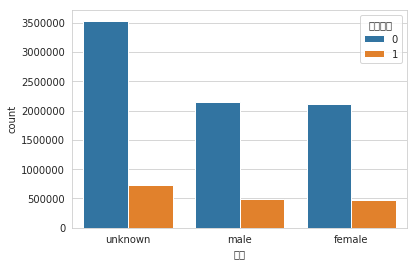

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

sns.countplot(x='性别', hue='是否回答', data=train)

plt.show()

**1.性别特征**:性别特征，有三种。其中男女的各自分布比较相似，未知的分布相比较之下，有较大的区别，显然，该特征具有比较好的区分度。

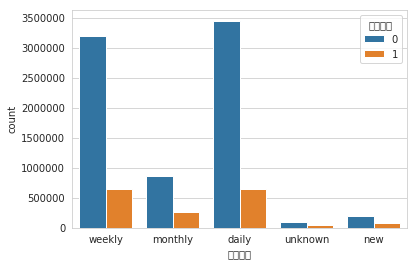

In [33]:
sns.countplot(x='访问评率',hue='是否回答',data=train)

**2.统计频率特征**: 该特征有五种类别，从下面的柱状图看出，不同的类别具有完全不同分布，是一种区分度很强的特征；

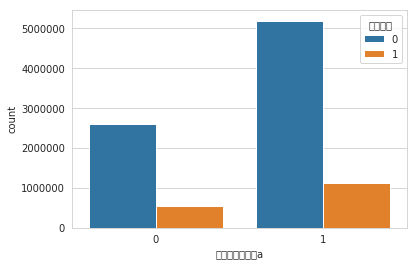

In [34]:
sns.countplot(x='用户二分类特征a',hue='是否回答',data=train)

**3.用户二分类特征a**：该特征是二分类特征，从图中可以看出很好的区分度。

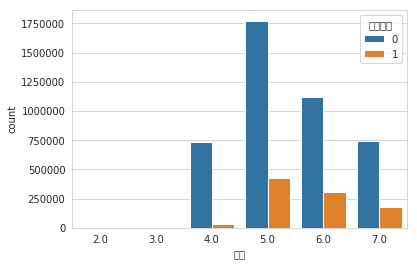

In [35]:
def trans(x):
    if x <= 0:
        return x
    if 1 <= x <= 10:
        return 1
    if 10 < x <= 100:
        return 2
    if 100 < x <= 200:
        return 3
    if 200 < x <= 300:
        return 4
    if 400 < x <= 500:
        return 5
    if 500 < x <= 600:
        return 6
    if x > 600:
        return 7
train['盐值'] = train['盐值'].apply(lambda x: trans(x))
sns.countplot(x='盐值',hue='是否回答',data=train)

**4.盐值**：先对盐值进行分桶，然后查看不同区间盐值的分布情况。下图表示不同区间盐值的用户具有很好的区分度，在处理这个特征，至于是否分桶，如何通过更加详细的数据分析自由发挥，给出的baseline对该特征未作处理。


**5.时间**：数据集中的时间都采用天和小时的格式，D代表天数，H代表小时，这里可以将一个特征转化为两个特征，天和小时。

**问题关联的topic和用户关注的topic的重叠数量**

#### 计算周/日趋势

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

#sns.countplot(x='邀请创建时间-day', hue='是否回答', data=data[:train1.shape[0]])
# sns.kdeplot(data['盐值'][data['是否回答']==1],color='b')
# sns.kdeplot(data['盐值'][data['是否回答']==0],color='r')
#x = data[data['是否回答']==1][feat].unique()

day_df = data[['问题创建时间-day','邀请创建时间-day','是否回答']]
print(day_df.head())
day_df['问题创建时间-weekday'] = data['问题创建时间-day'].map(lambda x: x%7)
day_df['邀请创建时间-weekday'] = data['邀请创建时间-day'].map(lambda x: x%7)
#print(day_df)

feat = '邀请创建时间-weekday'

series0 = day_df[day_df['是否回答']==0][feat].value_counts().astype(int).sort_index()
y0 = series0.values
x0 = series0.index
#print(series)

series1 = day_df[day_df['是否回答']==1][feat].value_counts().astype(int).sort_index()
y1 = series1.values
x1 = series1.index

# y0 = series0.values/(series0.values+series1.values)
# y1 = series1.values/(series0.values+series1.values)

#plt.plot(x0,y0,color='red')
plt.plot(x1,y1,color='blue')


plt.show()

### 3. 数据处理

In [1]:
import numpy as np
# 减少内存占用
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            
            if str(col_type)[:5] == 'float':
                df[col] = df[col].astype(np.float32)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [2]:
import pandas as pd
import os
import numpy as np

data_path = '../data'

# 导入数据
user_info = pd.read_csv(os.path.join(data_path, 'member_info_0926.txt'), header=None, sep='\t')
question_info = pd.read_csv(os.path.join(data_path, 'question_info_0926.txt'), header=None, sep='\t')
train1 = pd.read_csv(os.path.join(data_path, 'invite_info_0926.txt'), header=None, sep='\t')
test1 = pd.read_csv(os.path.join(data_path, 'invite_info_evaluate_1_0926.txt'), header=None, sep='\t')
member_question_feat = pd.read_hdf('member_question_feat.h5', key='data')  # 719116 d12
question_pre_feat_train = pd.read_hdf('question_answer_train.h5', key='data') 
user_pre_feat_train =  pd.read_hdf('user_answer_train.h5', key='data')
question_pre_feat_val = pd.read_hdf('question_answer_val.h5', key='data') 
user_pre_feat_val =  pd.read_hdf('user_answer_val.h5', key='data')

user_info.columns = ['用户id','性别','创作关键词','创作数量等级','创作热度等级','注册类型','注册平台','访问评率','用户二分类特征a','用户二分类特征b','用户二分类特征c','用户二分类特征d','用户二分类特征e','用户多分类特征a','用户多分类特征b','用户多分类特征c','用户多分类特征d','用户多分类特征e','盐值','关注话题','感兴趣话题']
user_info  = user_info.drop(['创作关键词','创作数量等级','创作热度等级','注册类型','注册平台'], axis=1)
question_info.columns = ['问题id','问题创建时间','问题标题单字编码','问题标题切词编码','问题描述单字编码','问题描述切词编码','问题绑定话题']

train1.columns = ['问题id', '用户id', '邀请创建时间','是否回答']
train1 = pd.merge(train1, user_info, how='left', on='用户id')

train1 = pd.merge(train1, question_info, how='left', on='问题id')

test1.columns = ['问题id', '用户id', '邀请创建时间']
test1 = pd.merge(test1, user_info, how='left', on='用户id')
test1 = pd.merge(test1, question_info, how='left', on='问题id')

# 数据合并
data = pd.concat([train1, test1], axis=0, sort=True)

print(data.info())
# 数据压缩
data = reduce_mem_usage(data)

# 用于保存提交结果
#result_append = data[['问题id', '用户id', '邀请创建时间']][train1.shape[0]:]

data['邀请创建时间-day'] = data['邀请创建时间'].apply(lambda x:x.split('-')[0].split('D')[1])
data['邀请创建时间-hour'] = data['邀请创建时间'].apply(lambda x:x.split('-')[1].split('H')[1])

data['问题创建时间-day'] = data['问题创建时间'].apply(lambda x:x.split('-')[0].split('D')[1])
data['问题创建时间-hour'] = data['问题创建时间'].apply(lambda x:x.split('-')[1].split('H')[1])

# 删除的特征并非不重要，相反这部分的数据很重要，如何处理这部分特征有很大的发挥空间，本baseline不涉及这些特征。
drop_feat = ['问题标题单字编码','问题标题切词编码','问题描述单字编码','问题描述切词编码','问题绑定话题', '关注话题','感兴趣话题','问题创建时间','邀请创建时间']
data  = data.drop(drop_feat, axis=1)

# 将用户和问题相关的话题重合率计算
data = pd.merge(data, member_question_feat, how='left', left_on=['用户id','问题id'], right_on=['author_id','question_id'])
# 数据压缩
data = reduce_mem_usage(data)
drop_feat = ['author_id','question_id']
data  = data.drop(drop_feat, axis=1)
print(data.info())

# 将question_answer特征加入
train2 = pd.merge(data[:train1.shape[0]], question_pre_feat_train, how='left', on='问题id' )
test2 = pd.merge(data[train1.shape[0]:], question_pre_feat_val, how='left', on='问题id' )
data = pd.concat([train2, test2], axis=0, sort=True)

print(data.info())
# 数据压缩
data = reduce_mem_usage(data)

# 将user_answer特征加入
train3 = pd.merge(data[:train1.shape[0]], user_pre_feat_train, how='left', on='用户id' )
test3 = pd.merge(data[train1.shape[0]:], user_pre_feat_val, how='left', on='用户id' )
data = pd.concat([train3, test3], axis=0, sort=True)

print(data.info())

# 数据压缩
data = reduce_mem_usage(data)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10630845 entries, 0 to 1141682
Data columns (total 25 columns):
关注话题        object
性别          object
感兴趣话题       object
是否回答        float64
用户id        object
用户二分类特征a    int64
用户二分类特征b    int64
用户二分类特征c    int64
用户二分类特征d    int64
用户二分类特征e    int64
用户多分类特征a    object
用户多分类特征b    object
用户多分类特征c    object
用户多分类特征d    object
用户多分类特征e    object
盐值          int64
访问评率        object
邀请创建时间      object
问题id        object
问题创建时间      object
问题描述切词编码    object
问题描述单字编码    object
问题标题切词编码    object
问题标题单字编码    object
问题绑定话题      object
dtypes: float64(1), int64(6), object(18)
memory usage: 2.1+ GB
None
Memory usage of dataframe is 2108.78 MB
Memory usage after optimization is: 1652.55 MB
Decreased by 21.6%
Memory usage of dataframe is 1571.45 MB
Memory usage after optimization is: 1459.92 MB
Decreased by 7.1%
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10630845 entries, 0 to 10630844
Data columns (total 22 columns):
性别               objec

In [3]:
user_topic_features = pd.read_hdf('user_topic_feat.h5', key='data')
data = pd.merge(data, user_topic_features, how='left', left_on=['用户id'], right_on=['author_id'])
data  = data.drop('author_id', axis=1)
data = reduce_mem_usage(data)
print(data.info())

Memory usage of dataframe is 6123.57 MB
Memory usage after optimization is: 5758.59 MB
Decreased by 6.0%
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10630845 entries, 0 to 10630844
Columns: 134 entries, u_a_i_diffday_max to std_interest_values
dtypes: float32(111), int16(2), int8(8), object(13)
memory usage: 5.6+ GB
None


In [4]:
print(data.columns.values)

['u_a_i_diffday_max' 'u_a_i_diffday_mean' 'u_a_i_diffday_min'
 'u_a_i_diffday_sum' 'u_a_i_diffhour_max' 'u_a_i_diffhour_mean'
 'u_a_i_diffhour_min' 'u_a_i_diffhour_sum' '性别' '是否回答' '用户id'
 '用户上次回答时间-day' '用户习惯回答时间-hour' '用户二分类特征a' '用户二分类特征b' '用户二分类特征c'
 '用户二分类特征d' '用户二分类特征e' '用户关联回答数' '用户多分类特征a' '用户多分类特征b' '用户多分类特征c'
 '用户多分类特征d' '用户多分类特征e' '用户平均举报数' '用户平均反对数' '用户平均取赞数' '用户平均回答字数'
 '用户平均回答是否被推荐' '用户平均回答是否被收入圆桌' '用户平均回答是否被标优' '用户平均感谢数' '用户平均收藏数'
 '用户平均是否包含图片' '用户平均是否包含视频' '用户平均没有帮助数' '用户平均点赞数' '用户平均评论数' '用户总举报数'
 '用户总反对数' '用户总取赞数' '用户总回答字数' '用户总回答是否被推荐' '用户总回答是否被收入圆桌' '用户总回答是否被标优'
 '用户总感谢数' '用户总收藏数' '用户总是否包含图片' '用户总是否包含视频' '用户总没有帮助数' '用户总点赞数' '用户总评论数'
 '用户最大举报数' '用户最大反对数' '用户最大取赞数' '用户最大回答字数' '用户最大回答是否被推荐' '用户最大回答是否被收入圆桌'
 '用户最大回答是否被标优' '用户最大感谢数' '用户最大收藏数' '用户最大是否包含图片' '用户最大是否包含视频' '用户最大没有帮助数'
 '用户最大点赞数' '用户最大评论数' '用户最近回答数-14天' '用户最近回答数-3天' '用户最近回答数-7天' '用户邀请_count'
 '用户邀请平均' '用户邀请方差' '用户邀请求和' '用户问题的话题关注重叠数' '用户问题的话题感兴趣重叠数' '盐值' '访问评率'
 '邀请创建时间-day' '邀请创建时间-hour' '问题id' '问题上次回答时间' '问题关联回

### 4.特征处理

**编码**：将离散型的特征通过LabelEncoder进行数字编码

In [5]:
from sklearn.preprocessing import LabelEncoder
class_feat = ['性别', '访问评率','用户多分类特征a','用户多分类特征b','用户多分类特征c','用户多分类特征d','用户多分类特征e']
encoder = LabelEncoder()
for feat in class_feat:
    encoder.fit(data[feat])
    data[feat] = encoder.transform(data[feat])

class_feat = ['用户id','问题id',]
encoder = LabelEncoder()
for feat in class_feat:
    data['编码前'+feat] = data[feat]
    encoder.fit(data[feat])
    data[feat] = encoder.transform(data[feat])

In [6]:
print(data[['问题id','编码前问题id']])

             问题id      编码前问题id
0          327358  Q2166419046
1          154388  Q1550017551
2          972853   Q604029601
3          379015  Q2350061229
4          405239  Q2443223942
5          983078   Q640765464
6         1026507   Q795459266
7          253947   Q190554387
8          268933  Q1958712851
9          594767   Q311993584
10          29148   Q110462128
11         915753  Q4265255633
12        1051672   Q885275494
13         748219  Q3667003932
14         618224  Q3203261036
15         110049  Q1392973250
16         781496  Q3785192737
17         489174  Q2743747344
18         223029  Q1795395339
19         375831   Q233889623
20        1025739   Q792624945
21         588335  Q3097516518
22         725489  Q3585956324
23         278899  Q1993990469
24         624674  Q3226256008
25         428129  Q2525843774
26         887223  Q4163388497
27         859262  Q4062946420
28         533976  Q2903515283
29          23418  Q1083988747
...           ...          ...
10630815

**构造计数特征**：对具有很好区分度的特征进行单特征计数（有明显提升）

In [9]:
for feat in ['邀请创建时间-day','邀请创建时间-hour','问题创建时间-day','问题创建时间-hour']:
    data[feat] = data[feat].astype('int16')

In [8]:
data['问题创建时间-weekday'] = data['问题创建时间-day'].map(lambda x: x%7)
data['邀请创建时间-weekday'] = data['邀请创建时间-day'].map(lambda x: x%7)

In [9]:
print(data.columns.values)

['u_a_i_diffday_max' 'u_a_i_diffday_mean' 'u_a_i_diffday_min'
 'u_a_i_diffday_sum' 'u_a_i_diffhour_max' 'u_a_i_diffhour_mean'
 'u_a_i_diffhour_min' 'u_a_i_diffhour_sum' '性别' '是否回答' '用户id'
 '用户上次回答时间-day' '用户习惯回答时间-hour' '用户二分类特征a' '用户二分类特征b' '用户二分类特征c'
 '用户二分类特征d' '用户二分类特征e' '用户关联回答数' '用户多分类特征a' '用户多分类特征b' '用户多分类特征c'
 '用户多分类特征d' '用户多分类特征e' '用户平均举报数' '用户平均反对数' '用户平均取赞数' '用户平均回答字数'
 '用户平均回答是否被推荐' '用户平均回答是否被收入圆桌' '用户平均回答是否被标优' '用户平均感谢数' '用户平均收藏数'
 '用户平均是否包含图片' '用户平均是否包含视频' '用户平均没有帮助数' '用户平均点赞数' '用户平均评论数' '用户总举报数'
 '用户总反对数' '用户总取赞数' '用户总回答字数' '用户总回答是否被推荐' '用户总回答是否被收入圆桌' '用户总回答是否被标优'
 '用户总感谢数' '用户总收藏数' '用户总是否包含图片' '用户总是否包含视频' '用户总没有帮助数' '用户总点赞数' '用户总评论数'
 '用户最大举报数' '用户最大反对数' '用户最大取赞数' '用户最大回答字数' '用户最大回答是否被推荐' '用户最大回答是否被收入圆桌'
 '用户最大回答是否被标优' '用户最大感谢数' '用户最大收藏数' '用户最大是否包含图片' '用户最大是否包含视频' '用户最大没有帮助数'
 '用户最大点赞数' '用户最大评论数' '用户最近回答数-14天' '用户最近回答数-3天' '用户最近回答数-7天' '用户邀请_count'
 '用户邀请平均' '用户邀请方差' '用户邀请求和' '用户问题的话题关注重叠数' '用户问题的话题感兴趣重叠数' '盐值' '访问评率'
 '邀请创建时间-day' '邀请创建时间-hour' '问题id' '问题上次回答时间' '问题关联回

In [13]:
#pd.options.display.max_columns = None
#pd.options.display.max_rows = None
#pd.set_option('display.width',100)

def creat_count_features(data):
    #count_feats = []
    for feat in ['用户id','问题id','性别', '访问评率','用户二分类特征a', '用户二分类特征b', '用户二分类特征c', '用户二分类特征d',
       '用户二分类特征e','用户多分类特征a','用户多分类特征b','用户多分类特征c','用户多分类特征d','用户多分类特征e','邀请创建时间-hour','问题创建时间-hour',
            '问题创建时间-weekday','邀请创建时间-weekday','问题创建时间-day']:
        col_name = '{}_count'.format(feat)
        #count_feats.append(col_name)
        data[col_name] = data[feat].map(data[feat].value_counts().astype(int)) #为每个特征，匹配上其每个值对应到的 该值出现的次数
        data.loc[data[col_name] < 2, feat] = -1 #为所有 只出现过一次的特征值 都设置成 -1
        data[feat] += 1 # 因为有的特征值本身为0，结合上一步的步骤，让已被设置为-1的值和原来为0的特征值 区分开来，所以上一步才设为-1，这一步统一加1，让所有特征值都保证都>= 0
        data[col_name] = data[feat].map(data[feat].value_counts().astype(int))
        data[col_name] = (data[col_name] - data[col_name].min()) / (data[col_name].max() - data[col_name].min()) #把所有值正则化一下，保证在0-1区间
    
    return data#, count_feats

data = creat_count_features(data)

# train_start = 3807
# train_end = 3860
# val_start = train_start + 7
# val_end = train_end + 7

# fortrain1 = creat_count_features(data[data['邀请创建时间-day']>=train_start][data['邀请创建时间-day']<=train_end])
# forval1 = creat_count_features(data[data['邀请创建时间-day']>=val_start][data['邀请创建时间-day']<=val_end])

# on_feats = [x for x in data.columns.values if x not in count_feats ]

# train3 = pd.merge(data[:train1.shape[0]], fortrain1, how='left', on= on_feats )
# test3 = pd.merge(data[train1.shape[0]:], forval1, how='left', on= on_feats)
# data = pd.concat([train3, test3], axis=0, sort=True)

# #print(data.head(30))
#     #break
# print(data.info())

In [14]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10630845 entries, 0 to 10630844
Columns: 157 entries, u_a_i_diffday_max to 问题创建时间-day_count
dtypes: float32(111), float64(19), int16(6), int64(11), int8(8), object(2)
memory usage: 7.2+ GB
None


In [15]:
data.to_hdf('data.h5', key='data')

In [16]:
data.index = range(len(data))

In [17]:
data_for_train1 = data[data['邀请创建时间-day']>=3861][data['邀请创建时间-day']<=3867]
data_for_test1 = data[train1.shape[0]:]

/home/jiyangguang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [18]:
data_for_train1.to_hdf('data_for_train.h5', key='data')
data_for_test1.to_hdf('data_for_test.h5', key='data')

### 4.2 user_answer 特征处理

### 5.模型训练和预测

In [19]:
import pandas as pd
import os
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
import numpy as np
import gc
from sklearn.utils import shuffle

In [2]:
data_path = '../data'
train1 = pd.read_csv(os.path.join(data_path, 'invite_info_0926.txt'), header=None, sep='\t')
test1 = pd.read_csv(os.path.join(data_path, 'invite_info_evaluate_1_0926.txt'), header=None, sep='\t')
data = pd.read_hdf('data.h5', key='data')

In [3]:
data_for_train1 = pd.read_hdf('data_for_train.h5', key='data')
data_for_test1 = pd.read_hdf('data_for_test.h5', key='data')

In [ ]:
def make_u_i_hr_pcrt(answer_info):
    t3 = answer_info
    t3 = answer_info.groupby('用户id')['邀请创建时间-hour'].agg('value_counts').to_frame()
    t3.columns = ['u_i_hr_count']
    t3 = t3.reset_index()
    answer_info = pd.merge(answer_info, t3, on=['用户id','邀请创建时间-hour'], how='left')
    

In [20]:
print(len(data_for_train1[data_for_train1['是否回答']==1]))

415013


In [21]:
print(len(data_for_train1))

2593669


In [22]:
train_len = train1.shape[0]
print(train_len)

9489162


In [23]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10630845 entries, 0 to 10630844
Columns: 157 entries, u_a_i_diffday_max to 问题创建时间-day_count
dtypes: float32(111), float64(19), int16(6), int64(11), int8(8), object(2)
memory usage: 7.1+ GB
None


In [24]:
has_saved = False
scores=[]

# data1 = data[:train1.shape[0]][data['邀请创建时间-day']<3863][data['邀请创建时间-day']>3837]
# data2 = data[:train1.shape[0]][data['邀请创建时间-day']<3868][data['邀请创建时间-day']>3862]

# del data1['邀请创建时间-day'],data2['邀请创建时间-day']

# y_train1 = data1['是否回答'].values
# X_train1 = data1.drop(['是否回答'], axis=1).values


# y_valid1 = data2['是否回答'].values
# X_valid1 = data2.drop(['是否回答'], axis=1).values



#X_train = data[:train1.shape[0]].drop(['是否回答'], axis=1).values
#y_train = data[:train1.shape[0]]['是否回答'].values


# X_test = data[train1.shape[0]:].drop(['是否回答'], axis=1).values


In [25]:
print(data_for_train1.columns.values)

['u_a_i_diffday_max' 'u_a_i_diffday_mean' 'u_a_i_diffday_min'
 'u_a_i_diffday_sum' 'u_a_i_diffhour_max' 'u_a_i_diffhour_mean'
 'u_a_i_diffhour_min' 'u_a_i_diffhour_sum' '性别' '是否回答' '用户id'
 '用户上次回答时间-day' '用户习惯回答时间-hour' '用户二分类特征a' '用户二分类特征b' '用户二分类特征c'
 '用户二分类特征d' '用户二分类特征e' '用户关联回答数' '用户多分类特征a' '用户多分类特征b' '用户多分类特征c'
 '用户多分类特征d' '用户多分类特征e' '用户平均举报数' '用户平均反对数' '用户平均取赞数' '用户平均回答字数'
 '用户平均回答是否被推荐' '用户平均回答是否被收入圆桌' '用户平均回答是否被标优' '用户平均感谢数' '用户平均收藏数'
 '用户平均是否包含图片' '用户平均是否包含视频' '用户平均没有帮助数' '用户平均点赞数' '用户平均评论数' '用户总举报数'
 '用户总反对数' '用户总取赞数' '用户总回答字数' '用户总回答是否被推荐' '用户总回答是否被收入圆桌' '用户总回答是否被标优'
 '用户总感谢数' '用户总收藏数' '用户总是否包含图片' '用户总是否包含视频' '用户总没有帮助数' '用户总点赞数' '用户总评论数'
 '用户最大举报数' '用户最大反对数' '用户最大取赞数' '用户最大回答字数' '用户最大回答是否被推荐' '用户最大回答是否被收入圆桌'
 '用户最大回答是否被标优' '用户最大感谢数' '用户最大收藏数' '用户最大是否包含图片' '用户最大是否包含视频' '用户最大没有帮助数'
 '用户最大点赞数' '用户最大评论数' '用户最近回答数-14天' '用户最近回答数-3天' '用户最近回答数-7天' '用户邀请_count'
 '用户邀请平均' '用户邀请方差' '用户邀请求和' '用户问题的话题关注重叠数' '用户问题的话题感兴趣重叠数' '盐值' '访问评率'
 '邀请创建时间-day' '邀请创建时间-hour' '问题id' '问题上次回答时间' '问题关联回

In [26]:
drop_feat = ['邀请创建时间-day','编码前用户id','编码前问题id']
# data  = data.drop(drop_feat, axis=1)
data1 = data_for_train1.drop(drop_feat, axis=1)
data2 = data_for_test1.drop(drop_feat, axis=1)

X_train = data1.drop(['是否回答'], axis=1).values
y_train = data1['是否回答'].values

X_test = data2.drop(['是否回答'], axis=1).values

In [27]:
print(data1.columns.values)

['u_a_i_diffday_max' 'u_a_i_diffday_mean' 'u_a_i_diffday_min'
 'u_a_i_diffday_sum' 'u_a_i_diffhour_max' 'u_a_i_diffhour_mean'
 'u_a_i_diffhour_min' 'u_a_i_diffhour_sum' '性别' '是否回答' '用户id'
 '用户上次回答时间-day' '用户习惯回答时间-hour' '用户二分类特征a' '用户二分类特征b' '用户二分类特征c'
 '用户二分类特征d' '用户二分类特征e' '用户关联回答数' '用户多分类特征a' '用户多分类特征b' '用户多分类特征c'
 '用户多分类特征d' '用户多分类特征e' '用户平均举报数' '用户平均反对数' '用户平均取赞数' '用户平均回答字数'
 '用户平均回答是否被推荐' '用户平均回答是否被收入圆桌' '用户平均回答是否被标优' '用户平均感谢数' '用户平均收藏数'
 '用户平均是否包含图片' '用户平均是否包含视频' '用户平均没有帮助数' '用户平均点赞数' '用户平均评论数' '用户总举报数'
 '用户总反对数' '用户总取赞数' '用户总回答字数' '用户总回答是否被推荐' '用户总回答是否被收入圆桌' '用户总回答是否被标优'
 '用户总感谢数' '用户总收藏数' '用户总是否包含图片' '用户总是否包含视频' '用户总没有帮助数' '用户总点赞数' '用户总评论数'
 '用户最大举报数' '用户最大反对数' '用户最大取赞数' '用户最大回答字数' '用户最大回答是否被推荐' '用户最大回答是否被收入圆桌'
 '用户最大回答是否被标优' '用户最大感谢数' '用户最大收藏数' '用户最大是否包含图片' '用户最大是否包含视频' '用户最大没有帮助数'
 '用户最大点赞数' '用户最大评论数' '用户最近回答数-14天' '用户最近回答数-3天' '用户最近回答数-7天' '用户邀请_count'
 '用户邀请平均' '用户邀请方差' '用户邀请求和' '用户问题的话题关注重叠数' '用户问题的话题感兴趣重叠数' '盐值' '访问评率'
 '邀请创建时间-hour' '问题id' '问题上次回答时间' '问题关联回答数' '问题创建时间-d

In [28]:
#y_pred = 0
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for index, (tr_idx, va_idx) in enumerate(kfold.split(X_train, y_train)):
#for index in range(1):
    print('*' * 30)
    
    X_train1, y_train1, X_valid1, y_valid1 = X_train[tr_idx], y_train[tr_idx], X_train[va_idx], y_train[va_idx]
    
    if not has_saved:
#         model_lgb = LGBMClassifier(boosting_type='gbdt', num_leaves=64, learning_rate=0.05, n_estimators=1500,
#                                max_bin=425, subsample_for_bin=50000, objective='binary', min_split_gain=0,
#                                min_child_weight=5, min_child_samples=10, subsample=0.8, subsample_freq=1,
#                                colsample_bytree=1, reg_alpha=3, reg_lambda=5, seed=1000, n_jobs=-1, silent=True)
        model_lgb = LGBMClassifier(n_estimators=2000, n_jobs=-1, objective='binary', seed=1000, silent=True)
        # 建议使用CV的方式训练预测。
        model_lgb.fit(X_train1, y_train1, 
             eval_names=['train','eval'],
             eval_metric=['logloss','auc'],
             eval_set=[(X_valid1, y_valid1)], #(X_train1, y_train1),
             early_stopping_rounds=50)
    else:
        with open('model.mdl', 'rb') as file:
            model = pickle.load(file)
    
    score = model_lgb.best_score_['eval']['auc']
    scores.append(score)
    #print('fold %d round %d : score: %.6f | mean score %.6f' % (index+1, model_lgb.best_iteration_, score, np.mean(scores))) 
   
    y_pred = model_lgb.predict_proba(X_test)[:,1]
    np.savetxt('y_pred%d.txt'%(index+1),y_pred)
    print('saved')


******************************
[1]	train's auc: 0.766402	train's binary_logloss: 0.426082
Training until validation scores don't improve for 50 rounds
[2]	train's auc: 0.777281	train's binary_logloss: 0.415608
[3]	train's auc: 0.783107	train's binary_logloss: 0.40713
[4]	train's auc: 0.788146	train's binary_logloss: 0.399918
[5]	train's auc: 0.789951	train's binary_logloss: 0.394209
[6]	train's auc: 0.792275	train's binary_logloss: 0.389234
[7]	train's auc: 0.795278	train's binary_logloss: 0.384704
[8]	train's auc: 0.797091	train's binary_logloss: 0.380953
[9]	train's auc: 0.798111	train's binary_logloss: 0.377674
[10]	train's auc: 0.799132	train's binary_logloss: 0.374838
[11]	train's auc: 0.800177	train's binary_logloss: 0.372344
[12]	train's auc: 0.801238	train's binary_logloss: 0.370002
[13]	train's auc: 0.801745	train's binary_logloss: 0.368129
[14]	train's auc: 0.802699	train's binary_logloss: 0.366374
[15]	train's auc: 0.803656	train's binary_logloss: 0.364698
[16]	train's auc: 

KeyError: 'auc'

In [30]:
model_lgb.booster_.save_model('model.txt')
pd.set_option('display.max_rows', None)

print(pd.DataFrame({
    'column': [x for x in data_for_train1.columns.values if x not in ['邀请创建时间-day','用户id','问题id','是否回答']],
    'importance': model_lgb.feature_importances_
}).sort_values(by='importance', ascending=False))

                   column  importance
74                   访问评率        3336
135            问题id_count        3270
134            用户id_count        2320
77                问题关联回答数        2059
9            用户上次回答时间-day        2037
76               问题上次回答时间        1762
80                问题平均举报数        1683
127   max_interest_values        1484
10          用户习惯回答时间-hour        1481
125   most_interest_topic        1459
131               编码前问题id        1336
128  mean_interest_values        1277
81                问题平均反对数        1259
26            用户平均回答是否被推荐        1232
148     邀请创建时间-hour_count        1200
21               用户多分类特征e        1174
40             用户总回答是否被推荐        1171
129   std_interest_values        1138
5     u_a_i_diffhour_mean        1138
145        用户多分类特征c_count        1136
152      问题创建时间-day_count        1128
7      u_a_i_diffhour_sum        1099
146        用户多分类特征d_count        1049
18               用户多分类特征b        1047
20               用户多分类特征d        1046
149     问题创建

## 生成结果


In [ ]:
pred_score = 0
for i in range(5):
    pred = pd.read_csv('y_pred%d.txt'%(i+1), header=None, sep='\t')
    pred_score += pred/5

print(pred_score)

In [32]:
# data_path = '../data'
# y_pred = pd.read_csv('y_pred1.txt', header=None, sep='\t')

result = pd.read_csv(os.path.join(data_path, 'invite_info_evaluate_1_0926.txt'), header=None, sep='\t')
result['pred_score']=pred_score

result.to_csv('result.txt',index=False, header=False, sep='\t')